### Stage 0: Configuration and pre-processing
Import dependencies and read the auction listing as a pandas dataframe.

In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv('input.csv')

### Stage 1: Filtering by completion date
Filter out projects that cannot feasibly be completed in time to reach out target capacity of 8 GW by 2030.

- When 'Auction format' is 'Central', a total of 5 years from winning the bid are required from winning the bid to implement the project. 
- When 'Auction format' is 'Lease', a total of 7 years from winning the bid are required for project completion.

Source: Case

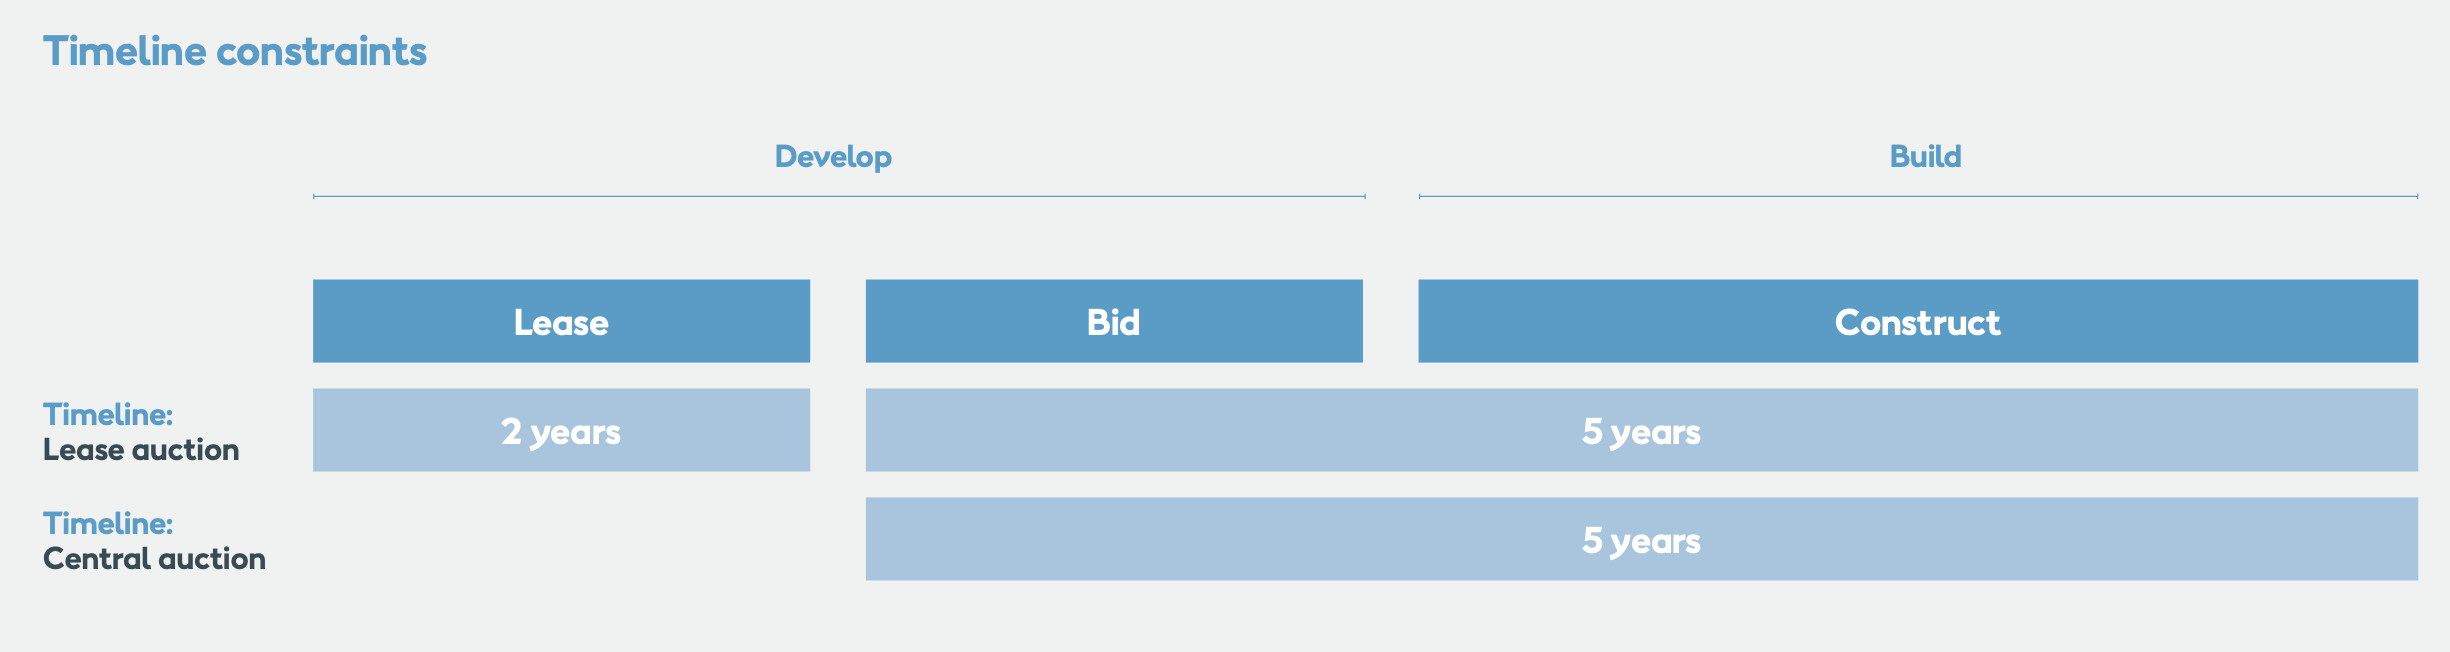


In [17]:
df = df[((df['Auction format'] == 'Central') & (df['Year'] <= 2025)) | ((df['Auction format'] == 'Lease') & (df['Year'] <= 2023))]

### Stage 2: Calculating base price

**User-supplied input:** 

Dictionaries representing the following:
- Market type for each country
- Development expenditures for each market type, where the auction type is central
- Development expenditures for all market types, where the auction type is lease
- Capital expenditures per GW built for fixed and floating types
- Capital expenditures/additional costs for all differentiating initiative types

##### 2a: Market type for each country

**Case excerpt**

Market segmentation
Note:

When evaluating offshore auctions, in this case you can distinguish between three market types: core, adjacent, and new.
- **Core** markets are those in which Ørsted already operates offshore wind, such as Denmark or the UK (e.g. has installed capacity).
- **Adjacent** markets are those without current capacity (in- stalled or under construction), but which are close to countries with installed capacity or projects under construction. An example is Norway, as it is proximate to the core DK market.
- **New** markets are those in which Ørsted currently has no installed capacity or projects under construction nearby such as Brazil and Australia.

Ørsted does not operate with clear distinction, but evaluates projects on a case basis, and it is therefore up to you to rationalise and estimate the market classifications for your choice of auctions. You should consider Ørsted’s operations in each market when forming your solutions.

**Team assumptions and rationale**
According to the case excerpt, we have categorized all markets with completed installations as **core** markets. The category of **adjacent** market has been awarded on a case basis, with justification provided in a comment. **New** markets follow the same definition as given in the excerpt.

Source: Case, team definitions

In [18]:
# Market type for each country
country_market_type = {
    'Denmark' : 'core', # 1.0 GW installed
    'Germany' : 'core', # 1.3 GW installed
    'Taiwan' : 'core', # <0.1 GW installed
    'Japan' : 'new', # add'l cap. under dev.
    'Lithuania' : 'adjacent', # land border with Poland, which will soon begin constructing its awarded projects
    'France' : 'adjacent', # land border with Germany, a core market with similar or shared regulations
    'Netherlands': 'core', # 0.8 GW installed
    'Belgium' : 'adjacent', # land border with Netherlands, a core market with similar or shared regulations
    'Portugal' : 'new', # no proximate land border and faces out into the Atlantic
    'United Kingdom' : 'core', # 5.7 GW installed
    'United States' : 'core', # <0.1 GW installed
    'Norway' : 'adjacent', # proximate to Denmark, given in case
    'Germany' : 'core', # 1.3 GW installed
    'Canada' : 'adjacent', # proximate to US, with < 0.1 GW, 0.1 GW recorded
    'Poland': 'adjacent', # land border with Germany, a core market with similar or shared regulations
}

##### 2b: Development expenditures for each market type, where the auction type is central

**Case excerpt** 

For central auctions, DEVEX costs vary depending on how familiar Ørsted is with the regulatory and competitive environment. For central auctions, it is reasonable to assume that it costs approximately...
- 75 DKKm in DEVEX to develop a bid in a core market for Ørsted
- 100 DKKm in DEVEX to develop a bid in an adjacent market (with high proximity to a core market, geographically and regulatory-wise)
- 125 DKKm in DEVEX to develop a bid in a completely new market for
Ørsted
- You can assume that ‘market familiarity’ is unaffected by auction wins that occur after 2022, and that DEVEX is therefore independent across auctions.

Source: Case

In [19]:
# Development expenditures for each market type, where the auction type is central
central_devex = {
    'core' : 75_000_000,
    'adjacent' : 100_000_000,
    'new' : 125_000_000
}

##### 2c: Development expenditures for each market type, where the auction type is lease

**Case excerpt** 

For lease auctions, DEVEX is by default significantly larger and thus relatively unaffected by Ørsted’s existing familiarity with the regulatory environment, but instead depends greatly on the GW-scale of the auction. For lease auctions, it is reasonable to assume that it costs approximately...
- 1DKKbn per GW to develop a bid in all markets. This applies only to the GW that can be expected to be won, equal to 20% of the total capacity.

Source: Case

In [20]:
# Development expenditures for each market type, where the auction type is central
lease_devex = {
    'core' : 1_000_000_000,
    'adjacent' : 1_000_000_000,
    'new' : 1_000_000_000
}

##### 2d: Capital expenditures for each market type, where the auction type is lease

**Case excerpt** 

 For all offshore wind projects (regardless of auction type) it is reasonable to assume that it costs approximately...
- 20 DKKbn per GW to construct a wind farm project (as a baseline, meaning using fixed technology and with no differentiation)
- 5 DKKbn per GW in additional costs to construct a wind farm project using floating technology (relative to fixed technology)
- 200 DKKm in additional costs to create a minor (incremental, often con- struction-based) technological innovation differentiation initiative
- 150 DKKm in additional costs to create a standard local content differenti- ation initiative
- 100 DKKm in additional costs to create a standard sustainability and/or biodiversity differentiation initiative


Source: Case

In [21]:
variable_capex = { # wind projects proper
    'fixed' : 20_000_000_000, # per GW
    'floating' : 25_000_000_000 # per GW, noted as 5 DKKbn + fixed
}

fixed_capex = { # differential initiatives
    'minor_technological_innovation' : 200_000_000,
    'standard_local_content' : 150_000_000,
    'standard_sustainability' : 100_000_000,
    'standard_biodiversity' : 100_000_000
}

##### 2e: Differential initiatives for each country

**Case excerpt** 
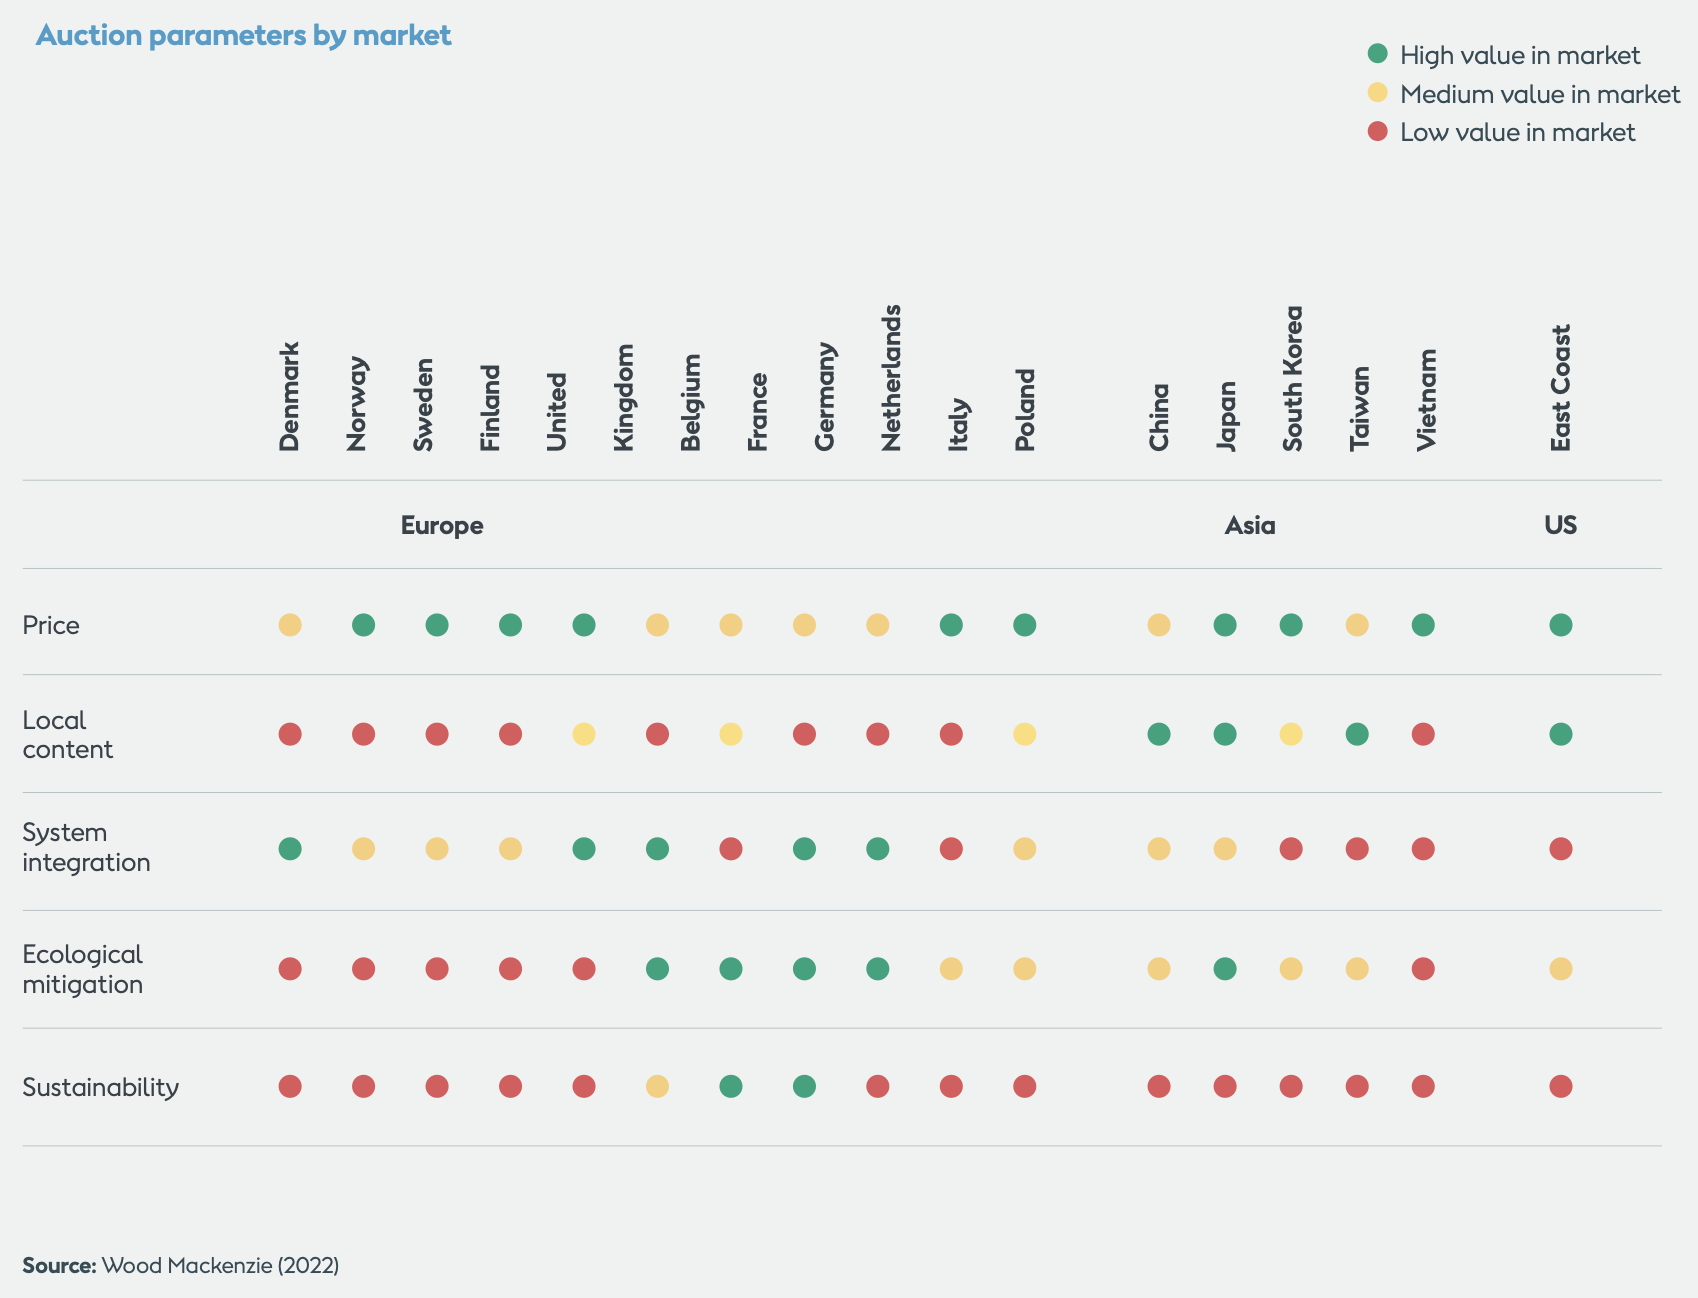

**Team assumptions and rationale**
Based on the red-amber-green diagram shown above, we propose the following:
- For countries that are more price-sensitive (green price dot), we employ only the differentiating initiatives that have a high value in market (green initiative dot).
- For countries that are less price-sensitive (yellow price dot), we employ differentiating initiatives that have a high or medium value in market (yellow or green initiative dot).

- Local content = 'standard_local_content'
- System integration = 'minor_technological_innovation' 
- Ecological mitigation = 'standard_biodiversity'
- Sustainability = 'standard_sustainability'

Source: Case, team definitions

In [22]:
country_differentiatial_initiatives = {
    # Europe
    'Denmark' : ['minor_technological_innovation'],
    'Norway' : [],
    'Sweden' : [],
    'Finland' : ['minor_technological_innovation'],
    'United Kingdom' : [],
    'Belgium' : ['minor_technological_innovation', 'standard_biodiversity', 'standard_sustainability'],
    'France' : ['standard_local_content', 'standard_biodiversity', 'standard_sustainability'],
    'Germany' : ['minor_technological_innovation', 'standard_biodiversity', 'standard_sustainability'], 
    'Netherlands' : ['minor_technological_innovation', 'standard_biodiversity'],
    'Italy' : [],
    'Poland': [],
    'Lithuania': [],
    'Portugal': [],

    # Asia
    'China' : ['standard_local_content', 'minor_technological_innovation', 'standard_biodiversity'],
    'Japan' : ['standard_local_content'],
    'South Korea' : [],
    'Taiwan' : ['standard_local_content', 'standard_biodiversity'],
    'Vietnam' : [],

    # US
    'United States' : ['standard_local_content']


}

##### 2f: Calculation step

**Methodology** 

Sum components to obtain a base price while also calculating CAPEX and DEVEX.

In [23]:
# Relate country to market type
df['market_type'] = df['Country'].map(country_market_type)

# Calculate DEVEX
conditions = [
    (df['Auction format']=='Lease') & (df['market_type']=='core'),
    (df['Auction format']=='Lease') & (df['market_type']=='adjacent'),
    (df['Auction format']=='Lease') & (df['market_type']=='new'),
    (df['Auction format']=='Central') & (df['market_type']=='core'),
    (df['Auction format']=='Central') & (df['market_type']=='adjacent'),
    (df['Auction format']=='Central') & (df['market_type']=='new')
]
choices = [lease_devex['core'], lease_devex['adjacent'], lease_devex['new'], central_devex['core'], central_devex['adjacent'], central_devex['new']]

df['devex'] = np.select(conditions, choices, default=0.0)

# Calculate variable CAPEX
df['variable_capex'] = np.where((df['Technology']=='Fixed') | (df['Technology']=='Optional'), variable_capex['fixed'], variable_capex['floating'])

df['variable_capex'] = np.where((df['Auction format'])=='Central', df['variable_capex'] * df['Capacity (GW)'], df['variable_capex'] * df['Capacity (GW)'] * 0.2)

#Calculate fixed CAPEX
for i, row in df.iterrows():
    differential_initiatives = country_differentiatial_initiatives[row['Country']]
    costs = 0
    for initiative in differential_initiatives:
        costs += fixed_capex[initiative]
    df.at[i,'fixed_capex'] = costs

df['capex'] = df['variable_capex'] + df['fixed_capex']

### Stage 3: Estimating the likelihood of winning work

**User-supplied input:** 

- A list of 3-element tuples. Each tuple breaks down the bidding criteria for a specific tender/auction in the format (price%, deliverability%, other%). 

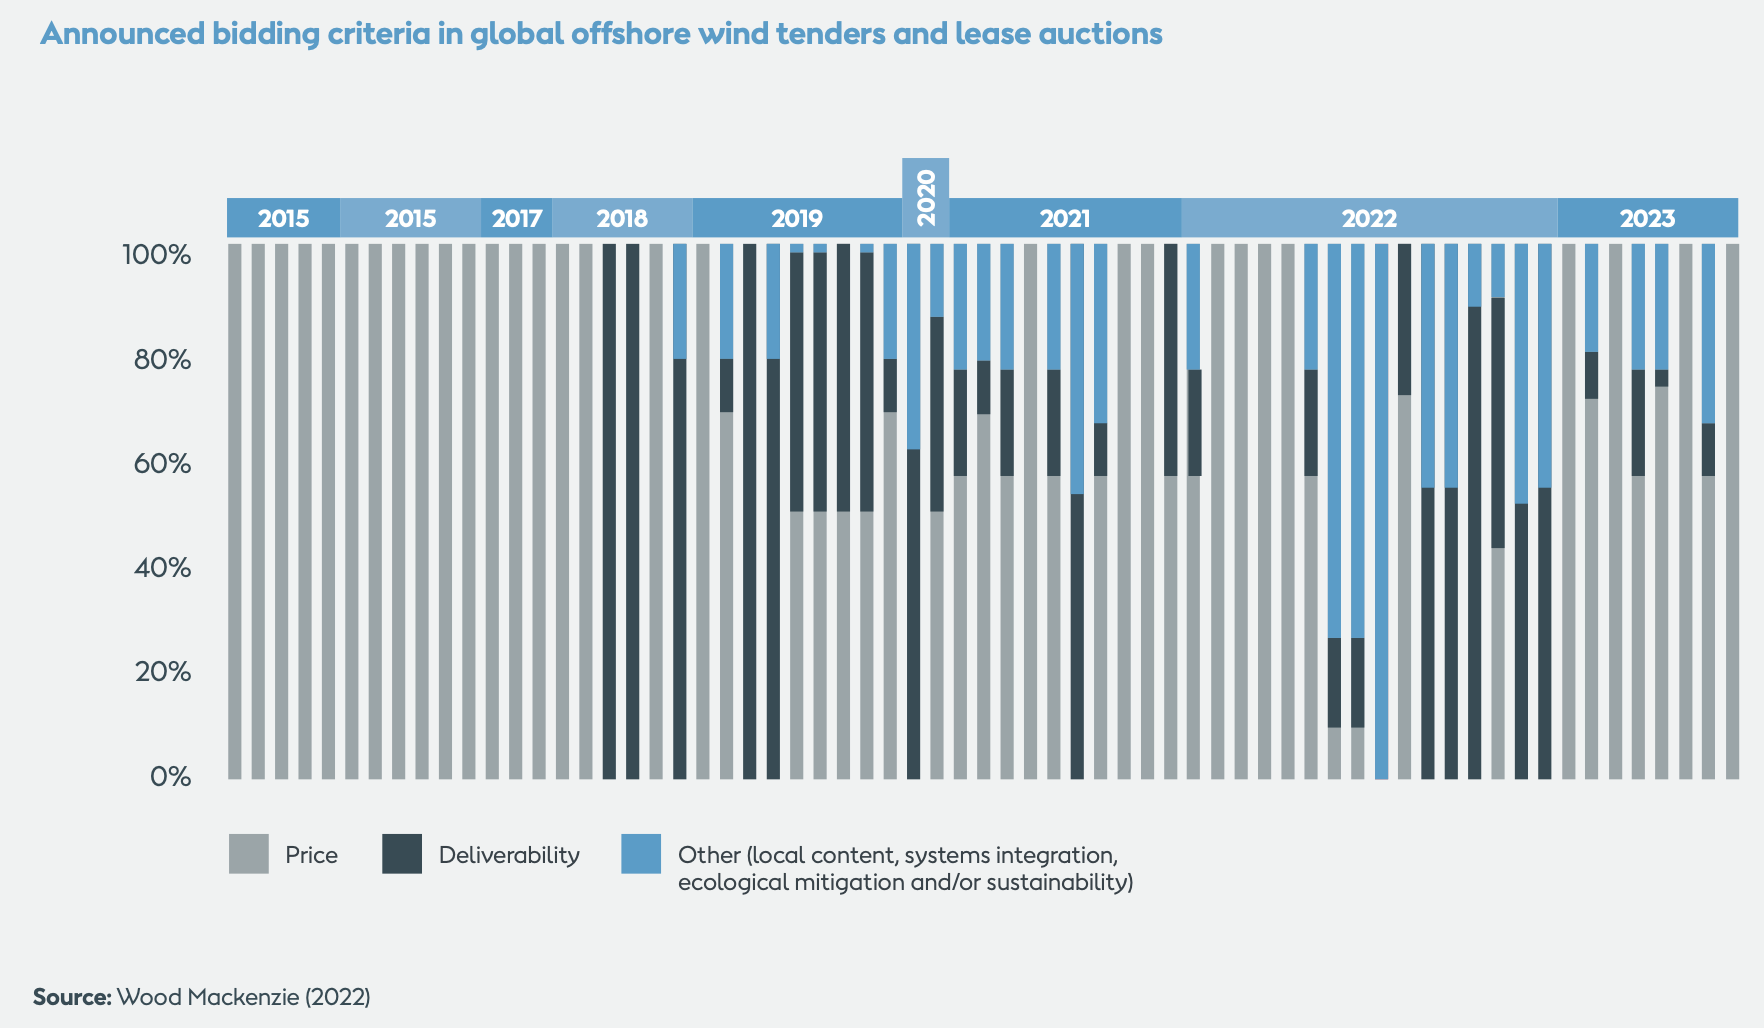

An average 3-element tuple is then calculated in the form (avg_price%, avg_deliverability%, avg_other%)

Next, each field is multiplied by a strength constant between 0 and 1 (0 to 100%), which represents Ørsted's ability to win work when considering each field.

- Price strength constant: how competitive are our prices?
- Deliverability strength constant: what is our track record with successfully completing projects?
- Other: how strong is Ørsted at each of the differentiating initiatives/6 pillars mentioned?

The sum of these fields yield a final value between 0 and 1, indicating how likely Ørsted is to win the auction. 

In [24]:
# List of 3-element tuples: given in the case diagram above

criteria_list = [
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (100,0,0),
    (0,100,0),
    (0,100,0),
    (0,100,0),
    (0,0,100),
    (0,50,50),
    (0,50,50),
    (0,50,50),
    (0,50,50),
    (0,80,20),
    (0,80,20),
    (0,60,40),
    (50,40,10),
    (60,15,25),
    (60,15,25),
    (60,15,25),
    (60,8,32),
    (60,40,0),
    (60,18,22),
    (60,18,22),
    (70,30,0),
    (0,90,10),
    (45,45,10),
    (0,50,50),
    (60,20,20),
    (60,10,30),
    (70,5,25),
    (70,10,20),
    (65,12,23),
    (70,10,20),
    (70,10,20),
    (50,45,5),
    (50,45,5),
    (50,45,5),
    (10,15,75),
    (10,15,75)
]

# Average 
average_distribution = [sum(y)/len(y) for y in zip(*criteria_list)]
print(average_distribution)


[64.375, 21.03125, 14.59375]


##### 3b: Hardcoded strength constants

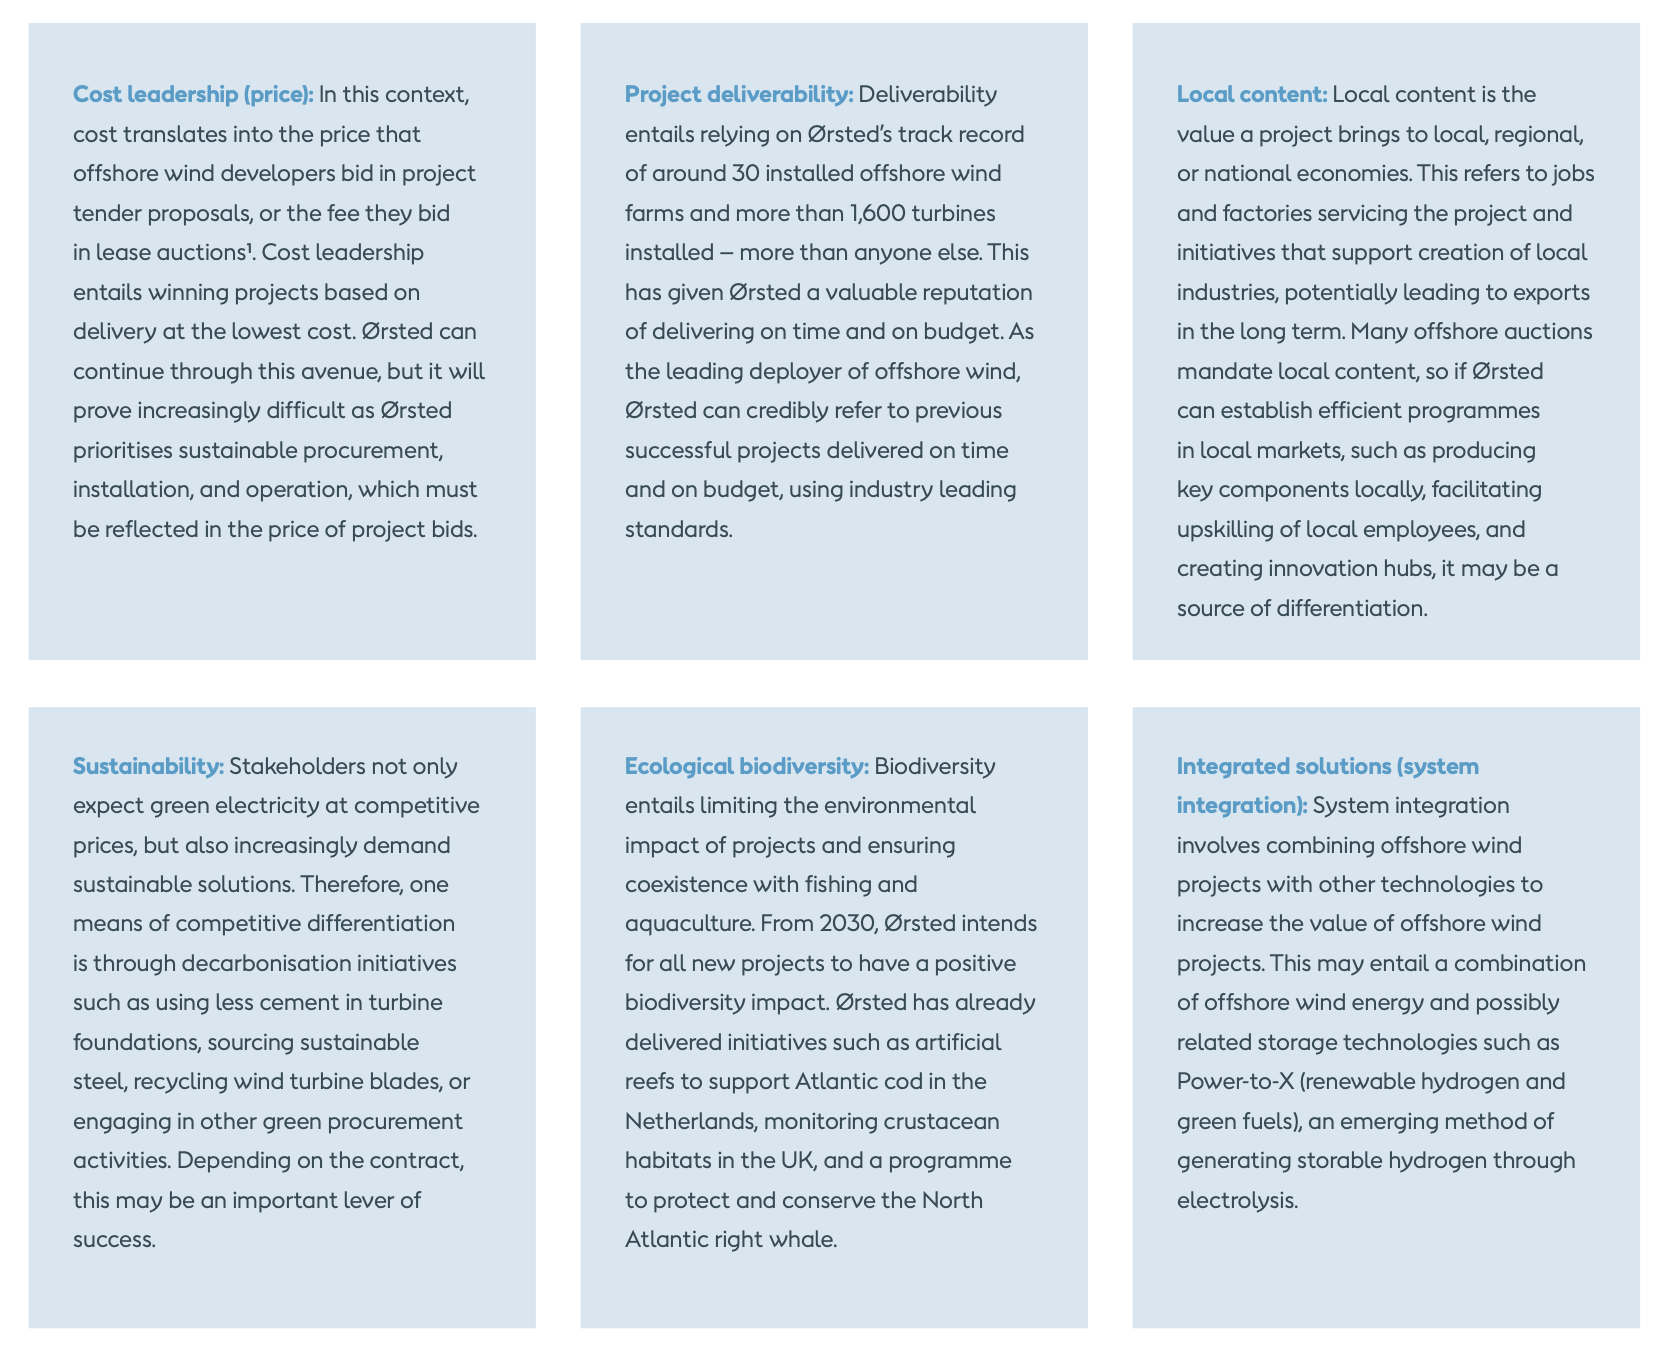

See comments below for justification of each constant's rating.

In [25]:
# Define strength constants (hardcoded)

# Orsted has an unparalleled track record and is the clear industry leader in delivering vast quantities of projects on time and on budget. For this, it is awarded a 1/1.
deliverability_strength = 1

# Recently, Ørsted has been featured as one of the top ten business transformations of the decade in the Harvard Business Review, and the world’s most sustainable energy company from 2019-2022 by Corporate Knights, coming in second among energy companies in the rating of 2023. For this, it is awarded a 1/1.
sustainability_strength = 1

# From 2030, Ørsted intends for all new projects to have a positive biodiversity impact. Ørsted has already delivered initiatives such as artificial reefs to support Atlantic cod in the Netherlands, monitoring crustacean habitats in the UK, and a programme to protect and conserve the North Atlantic right whale. As Ørsted still has plenty of room for improvement, it is awarded a 70% for its efforts.
biodiversity_strength = 0.7

# P2X and other integrated solutions is a developing field for Ørsted and the industry overall. While successful trials have been run, Ørsted has not yet cemented itself as a clear market leader in this area. For this, it is awarded a 65% for its efforts.
integrated_solution_strength = 0.65

# Ørsted has identified opportunities for growth in this area, but has not yet established strong partnerships or a track history of success. If Ørsted can establish efficient programmes in local markets, such as producing key components locally, facilitating upskilling of local employees, and creating innovation hubs, then it will improve and lead in this area.
local_content_strength = 0.4

# These are then stored in a differential initiative strength dictionary for easy access.
strength_dictionary = {
    'minor_technological_innovation' : integrated_solution_strength,
    'standard_local_content' : local_content_strength,
    'standard_sustainability' : sustainability_strength,
    'standard_biodiversity' : biodiversity_strength
}

##### 3c: Derived and overall strength constants

other_strength is derived on an auction-by-auction basis, depending on what each country seeks (i.e. the dictionary country_differentiatial_initiatives). Each differential initiative sought is multiplied by the four latter strength constants shown in the cell above and an average taken to yield other_strength.

price_strength is inversely proportional to other_strength; evidently, the more that is spent on differential initiatives, the less competitive the price of the bid overall. Its equation is given as (100% -15% * # of differential initiatives required). After a fractional proportion approach failed to accurately reflect a decrease of competitiveness, we resorted to a straight-line 15% decrease. This metric compares CAPEX spent on constructing the plant with total CAPEX including differential initiatives. 

deliverability_strength is previously defined.

In [26]:
# Derive other_strength for each auction.
# Derive price_strength for each auction.
for i, row in df.iterrows():
    differential_initiatives = country_differentiatial_initiatives[row['Country']]
    other_strength = 0
    if len(differential_initiatives) != 0:
        for initiative in differential_initiatives:
            other_strength += strength_dictionary[initiative]
        other_strength = other_strength / len(differential_initiatives)
    else:
        other_strength = 1
    df.at[i,'other_strength'] = other_strength
    df.at[i, 'price_strength'] = 1 - 0.1 * len(differential_initiatives)
    df.at[i, 'deliverability_strength'] = deliverability_strength

# Former equation for price_strength, which had a range of .97 to 1.0 (does not represent competitiveness)
# df['price_strength'] = df['variable_capex']/df['capex']

##### 3d: Calculate likelihood of winning each auction

Using the average breakdown of bidding criteria, the strength of each criteria—price, deliverability, other—is proportionally scaled to yield a fraction representing the likelihood of the job being won.

In [27]:
# Calculate likelihood of winning the auction

df['predicted_success'] = (df['price_strength'] * average_distribution[0] + df['deliverability_strength'] * average_distribution[1] + df['other_strength'] * average_distribution[2])/100

### Stage 4: Determine true price, true capacity (GW) gained, and the true GW per dollar spent ratio (assessment score).

We now calculate the true price, which is defined as DEVEX + (CAPEX * predicted_success). 

In other words, true price describes "how much we will likely pay" if we pursue a given bid. DEVEX is always spent as it is the cost of bidding in the auction. CAPEX is scaled relative to the probability of winning the work, i.e. the funds actually being spent. 

Similarly, true capacity is calculated by multiplying the given capacity (GW) of a project by the likelihood of success.

Once both factors are scaled, we can elect to pursue a certain number of projects and trust that our calculations reflect better approximations of spending and new capacity (GW) obtained.

Finally, we divide the true capacity by the true price to find the true GW per dollar spent ratio. We use this as our assessment score. Evidently, higher is better—the more energy generation potential that may be repeated per dollar spent, the better our funds are being used.

In [28]:
# Calculate true price
df['true_price'] = df['devex'] + df['predicted_success'] * df['capex']

# Calculate true capacity
df['true_capacity'] = np.where((df['Auction format']=='Lease'), df['Capacity (GW)'] * df['predicted_success'] * 0.2, df['Capacity (GW)'] * df['predicted_success'])

# Generate the assessment score, or true GW per dollar spent ratio.
# Multiply by 1,000,000,000 for better readability. This is purely visual and normalizes the value.
df['assessment_score'] = df['true_capacity'] / df['true_price'] * 100_000_000_000

df = df.sort_values(by=['assessment_score'], ascending=False)

In [29]:
df.to_csv('output.csv', sep=',', encoding='utf-8')